In [ ]:
#Installing relevant packages
! pip install afinn
! pip install scikit-plot
! pip install umap-learn

     |████████████████████████████████| 52 kB 763 kB/s 
  Created wheel for afinn: filename=afinn-0.1-py3-none-any.whl size=53448 sha256=44e703cb2ff309e3fb1f0290feadb5e8a933d66d8dd5828a1baee6d12db79aa8
  Stored in directory: /root/.cache/pip/wheels/9d/16/3a/9f0953027434eab5dadf3f33ab3298fa95afa8292fcf7aba75
Successfully built afinn
     |████████████████████████████████| 86 kB 2.8 MB/s 
     |████████████████████████████████| 1.1 MB 22.8 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82709 sha256=39297f54151b78f65950d2e51d860ab2a88c737d60f85ae523b40d67c44a3c81
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.5-py3-none-any.whl size=52603 sha256=e545006386cc27372c8f9a5cee8d4a8b9e59a325a75f08554e5cab6eabdc5262
  Stored in directory: /root/.cache/pip/wheels/af/e9/33/04db1436df0757c42fda8ea6796d7a8586e23c85fac355f476
Successfully built u

In [ ]:
#Importing relevant packages
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

from afinn import Afinn
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer,TfidfVectorizer 
from wordcloud import WordCloud

from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.spatial.distance import pdist, squareform

from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import MDS
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import scikitplot as skplt

import nltk
from nltk.tokenize import word_tokenize, TweetTokenizer
from nltk.corpus import stopwords

import spacy
from spacy import cli
from spacy import displacy
import umap.umap_ as umap

from keybert import KeyBERT

In [ ]:
from google.colab import drive
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


#**1. Data Cleaning**

In [ ]:
#adapt file path to where your Team Project foler is (from '/Team_project...' it is the same for everyone)
#data = pd.read_json('/drive/My Drive/BA820/Team_Project/renttherunway_final_data.json', lines=True)

data = pd.read_json('/Users/kratikbiswari/Downloads/renttherunway_final_data.json', lines=True)

In [ ]:
data.rename(columns={'bust size': 'bust_size', 'rented for': 'rented_for', 'body type':'body_type'}, inplace=True)

In [ ]:
#Previewing data
data.sample(5)

,fit,user_id,bust_size,item_id,weight,rating,rented_for,review_text,body_type,review_summary,category,height,size,age,review_date
167934,fit,442108,36c,1605839,140lbs,8.0,wedding,I wore this to a friend's wedding and received...,NaN,Wedding at a winery.,dress,"5' 7""",12,29.0,"May 16, 2017"
21627,fit,646926,36d,123793,180lbs,10.0,other,I wore this dress for my 30th Great Gatsby the...,full bust,Birthday Star!,gown,"5' 8""",25,34.0,"November 23, 2013"
136994,fit,858560,36c,1678888,145lbs,10.0,formal affair,I am obsessed with this dress. I loved wearing...,athletic,LOVED this dress. Would buy if possible,dress,"5' 6""",16,28.0,"November 2, 2017"
146692,fit,539541,36c,963476,136lbs,10.0,formal affair,I wore this dress to my boyfriend's fraternity...,athletic,Tasteful & gorgeous - wish I could've kept it!,sheath,"5' 5""",12,22.0,"May 19, 2014"
29838,fit,646468,NaN,265806,NaN,10.0,other,wore this to my friend's NASCAR race in Texas ...,NaN,Great dress for NASCAR race!,maxi,"5' 5""",1,25.0,"July 11, 2016"


In [ ]:
data.shape

(192544, 15)

In [ ]:
data.item_id.count()

192544

In [ ]:
#Overview of dataframe structure
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192544 entries, 0 to 192543
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   fit             192544 non-null  object 
 1   user_id         192544 non-null  int64  
 2   bust_size       174133 non-null  object 
 3   item_id         192544 non-null  int64  
 4   weight          162562 non-null  object 
 5   rating          192462 non-null  float64
 6   rented_for      192534 non-null  object 
 7   review_text     192544 non-null  object 
 8   body_type       177907 non-null  object 
 9   review_summary  192544 non-null  object 
 10  category        192544 non-null  object 
 11  height          191867 non-null  object 
 12  size            192544 non-null  int64  
 13  age             191584 non-null  float64
 14  review_date     192544 non-null  object 
dtypes: float64(2), int64(3), object(10)
memory usage: 22.0+ MB


##1.1 Dealing with missing values

In [ ]:
data.isna().sum()

fit                   0
user_id               0
bust_size         18411
item_id               0
weight            29982
rating               82
rented_for           10
review_text           0
body_type         14637
review_summary        0
category              0
height              677
size                  0
age                 960
review_date           0
dtype: int64

In [ ]:
size_null = ['bust_size', 'weight', 'rented_for', 'body_type', 'height']
for i in size_null:
  i_sum = data.groupby(i).size().sort_values(ascending=False)
  print(i_sum.head(1))

bust_size
34b    27285
dtype: int64
weight
130lbs    14370
dtype: int64
rented_for
wedding    57784
dtype: int64
body_type
hourglass    55349
dtype: int64
height
5' 4"    28012
dtype: int64


In [ ]:
#bust size
data['bust_size'].fillna('34b', inplace=True)
#weight  
data['weight'].fillna('130lbs', inplace=True)
#rating
data['rating'].fillna(float(data['rating'].median()), inplace=True)
#rented for
data['rented_for'].fillna('wedding', inplace=True)
#body type 
data['body_type'].fillna('hourglass', inplace=True)
#height  
data['height'].fillna('5\' 4"', inplace=True)
#age
data['age'].fillna(float(data['age'].median()), inplace=True)

In [ ]:
data.isna().sum()

fit               0
user_id           0
bust_size         0
item_id           0
weight            0
rating            0
rented_for        0
review_text       0
body_type         0
review_summary    0
category          0
height            0
size              0
age               0
review_date       0
dtype: int64

In [ ]:
data.isna().sum().sum()

0

##1.2 Converting data type

In [ ]:
data['review_date'] = pd.to_datetime(data['review_date'])
data['weight'] = data.weight.str.replace('lbs', '')

In [ ]:
data.head(3)

,fit,user_id,bust_size,item_id,weight,rating,rented_for,review_text,body_type,review_summary,category,height,size,age,review_date
0,fit,420272,34d,2260466,137,10.0,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,"5' 8""",14,28.0,2016-04-20
1,fit,273551,34b,153475,132,10.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,"5' 6""",12,36.0,2013-06-18
2,fit,360448,34b,1063761,130,10.0,party,This hugged in all the right places! It was a ...,hourglass,It was a great time to celebrate the (almost) ...,sheath,"5' 4""",4,116.0,2015-12-14


In [ ]:
data['bust_size'].unique()

array(['34d', '34b', '34c', '32b', '34d+', '36d', '36a', '32d+', '36c',
       '32c', '32dd', '30dd', '32d', '36b', '34a', '34dd', '40ddd/e',
       '32a', '38d+', '38c', '34ddd/e', '38a', '38b', '38d', '36ddd/e',
       '38dd', '38f', '42dd', '36dd', '40g', '40dd', '28f', '30ddd/e',
       '32ddd/e', '28b', '36d+', '40d', '28dd', '34f', '42c', '30d',
       '30b', '42d', '34aa', '32aa', '36f', '28c', '40b', '36aa', '34g',
       '32f', '42ddd/e', '40c', '28g', '28aa', '36g', '30a', '44ddd/e',
       '30c', '30aa', '44dd', '32i', '32g', '30g', '38h', '30h', '34j',
       '38ddd/e', '32h', '28a', '44d', '40h', '38g', '34h', '36j', '40f',
       '36h', '28ddd/e', '44f', '34i', '30f', '36i', '30i', '28h', '42b',
       '42j', '32j', '46c', '48d', '38aa', '38i', '48dd', '28d', '28i',
       '46ddd/e', '42g', '44c', '42f', '40j', '38j', '46f', '44b', '44g',
       '42h', '40i', '44h'], dtype=object)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192544 entries, 0 to 192543
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   fit             192544 non-null  object        
 1   user_id         192544 non-null  int64         
 2   bust_size       192544 non-null  object        
 3   item_id         192544 non-null  int64         
 4   weight          192544 non-null  object        
 5   rating          192544 non-null  float64       
 6   rented_for      192544 non-null  object        
 7   review_text     192544 non-null  object        
 8   body_type       192544 non-null  object        
 9   review_summary  192544 non-null  object        
 10  category        192544 non-null  object        
 11  height          192544 non-null  object        
 12  size            192544 non-null  int64         
 13  age             192544 non-null  float64       
 14  review_date     192544 non-null  dat

In [ ]:
data['weight'] = data['weight'].astype('float64')

In [ ]:
def feet_to_float(cell_string):
    try:
        split_strings = cell_string.replace('"','').replace("'",'').split()
        float_value = float(split_strings[0])*12+float(split_strings[1])
    except:
        float_value = np.nan
    return float_value

In [ ]:
data['height'] = data['height'].apply(feet_to_float)

In [ ]:
data = data[data.age <= 100]
data = data[data['size'] <= 22]

In [ ]:
data.reset_index(drop=True,inplace= True)

In [ ]:
data.height

0         68.0
1         66.0
2         65.0
3         69.0
4         68.0
          ... 
171123    69.0
171124    61.0
171125    68.0
171126    66.0
171127    66.0
Name: height, Length: 171128, dtype: float64

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171128 entries, 0 to 171127
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   fit             171128 non-null  object        
 1   user_id         171128 non-null  int64         
 2   bust_size       171128 non-null  object        
 3   item_id         171128 non-null  int64         
 4   weight          171128 non-null  float64       
 5   rating          171128 non-null  float64       
 6   rented_for      171128 non-null  object        
 7   review_text     171128 non-null  object        
 8   body_type       171128 non-null  object        
 9   review_summary  171128 non-null  object        
 10  category        171128 non-null  object        
 11  height          171128 non-null  float64       
 12  size            171128 non-null  int64         
 13  age             171128 non-null  float64       
 14  review_date     171128 non-null  dat

In [ ]:
data.sample(3)

,fit,user_id,bust_size,item_id,weight,rating,rented_for,review_text,body_type,review_summary,category,height,size,age,review_date
57546,large,405605,34d,985499,130.0,6.0,wedding,I didn't like the feel of this material at all...,full bust,I didn't like the feel of this material at all...,gown,65.0,3,29.0,2015-11-17
21750,fit,375628,34c,782555,120.0,10.0,wedding,The fit was true to size and I loved that I di...,straight & narrow,This was one of my favorite dresses that I've ...,dress,67.0,1,27.0,2016-06-16
19739,fit,102967,36c,168592,130.0,10.0,formal affair,"perfect fit, comfortable, sexy and glam at the...",apple,The event was held at a Fine Arts museum and i...,gown,64.0,16,45.0,2014-12-15


#**2. Exploratory Data Analysis**

In [ ]:
data.drop(columns=['rented_for','review_text','body_type','review_summary','category'])

,fit,user_id,bust_size,item_id,weight,rating,height,size,age,review_date
0,fit,420272,34d,2260466,137.0,10.0,68.0,14,28.0,2016-04-20
1,fit,273551,34b,153475,132.0,10.0,66.0,12,36.0,2013-06-18
2,fit,909926,34c,126335,135.0,8.0,65.0,8,34.0,2014-02-12
3,fit,151944,34b,616682,145.0,10.0,69.0,12,27.0,2016-09-26
4,fit,734848,32b,364092,138.0,8.0,68.0,8,45.0,2016-04-30
...,...,...,...,...,...,...,...,...,...,...
171123,fit,66386,34dd,2252812,140.0,10.0,69.0,8,42.0,2016-05-18
171124,fit,118398,32c,682043,100.0,10.0,61.0,4,29.0,2016-09-30
171125,fit,47002,36a,683251,135.0,6.0,68.0,8,31.0,2016-03-04
171126,fit,961120,36c,126335,165.0,10.0,66.0,16,31.0,2015-11-25


In [ ]:
cor=data.drop(['user_id','item_id'],axis=1).corr()
cor

,weight,rating,height,size,age
weight,1.000000,-0.012407,0.423590,0.690500,0.030309
rating,-0.012407,1.000000,0.006693,-0.034957,-0.037978
height,0.423590,0.006693,1.000000,0.279740,-0.011386
size,0.690500,-0.034957,0.279740,1.000000,0.140178
age,0.030309,-0.037978,-0.011386,0.140178,1.000000


In [ ]:
print(data['fit'].unique())
print(len(data['body_type'].unique()))
print(len(data['category'].unique()))

['fit' 'small' 'large']
7
68


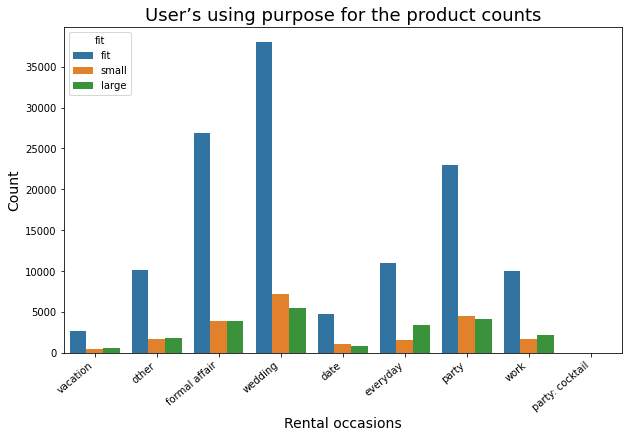

In [ ]:
plt.figure(figsize=(10,6))
a=sns.countplot(data=data,x='rented_for',hue='fit')
a.set_xticklabels(a.get_xticklabels(), rotation=40, ha="right")
plt.title('User’s using purpose for the product counts', size = 18)
plt.xlabel('Rental occasions', size = 14)
plt.ylabel('Count', size = 14)
plt.show()

From the graph above, we can see that most people rent clothes for weddings and formal affairs. Across all the renting purposes, most people found the size that fits their body. 


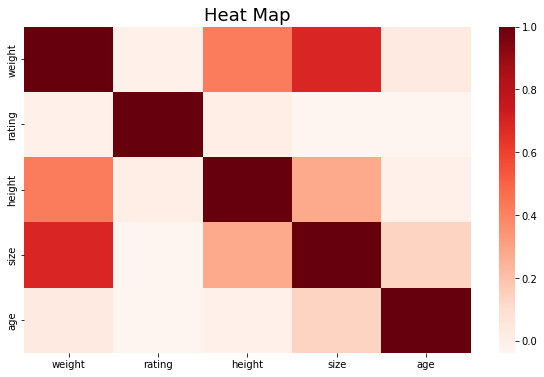

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(cor,cmap='Reds')
plt.title('Heat Map', size = 18)
plt.show()

We observed that the size of clothes is correlated with the user's weight and height based on the graph above. Especially weight, it has a significant positive correlation with the size of the clothes. Thus, we want to compare the user's weight and the clothing size they chose.


In [ ]:
data.describe()

,user_id,item_id,weight,rating,height,size,age
count,171128.000000,1.711280e+05,171128.000000,171128.000000,171128.000000,171128.000000,171128.000000
mean,498976.275414,1.067368e+06,132.791717,9.103969,65.223435,10.119805,33.545457
std,289591.388352,8.130746e+05,15.298126,1.422536,2.633416,5.742950,7.714472
min,9.000000,1.233730e+05,50.000000,2.000000,54.000000,0.000000,0.000000
25%,249023.250000,2.109045e+05,125.000000,8.000000,63.000000,4.000000,29.000000
50%,499439.000000,9.790160e+05,130.000000,10.000000,65.000000,8.000000,32.000000
75%,751151.750000,1.695878e+06,140.000000,10.000000,67.000000,14.000000,37.000000
max,999997.000000,2.966087e+06,250.000000,10.000000,78.000000,22.000000,100.000000


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


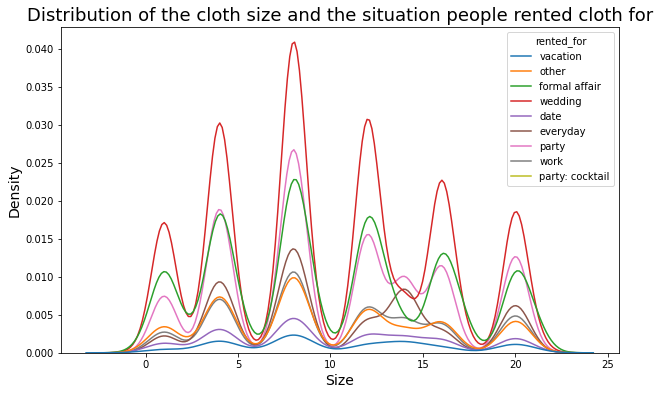

In [ ]:
plt.figure(figsize=(10,6))
sns.kdeplot(data=data,x='size',hue='rented_for')
plt.title('Distribution of the cloth size and the situation people rented cloth for', size = 18)
plt.xlabel('Size', size = 14)
plt.ylabel('Density', size = 14)
plt.show()

The graph from above shows the distribution of the cloth size and the situation people rented cloth for. We can notice that most sizes falls into the range between 5 and 15 for all purposes. 

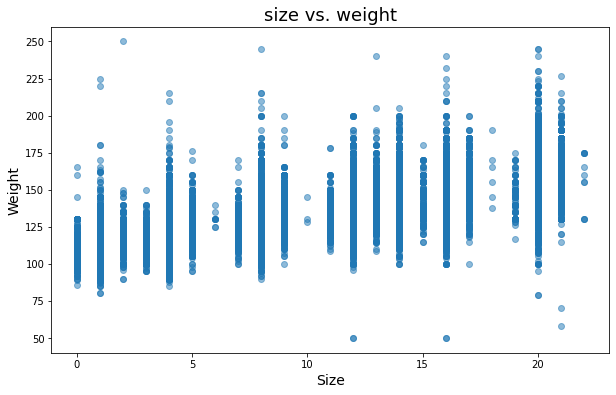

In [ ]:
#Size is most relevent to weight and height.
plt.figure(figsize=(10,6))
plt.scatter(x='size',y='weight', data=data, alpha=0.5)
plt.title('size vs. weight', size = 18)
plt.xlabel('Size', size = 14)
plt.ylabel('Weight', size = 14)
plt.show()

Illustrated by the graph from above, the x-axis represents the size and the y-axis represents the weight, we see there is a clear positive correlation, which makes sense since people who have more weight usually buy larger clothes

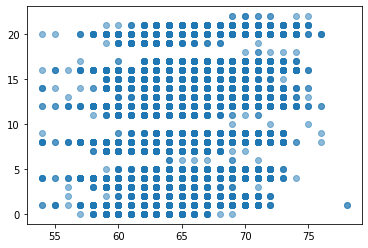

In [ ]:
plt.scatter('height', 'size', data=data, alpha=0.5)
plt.show()

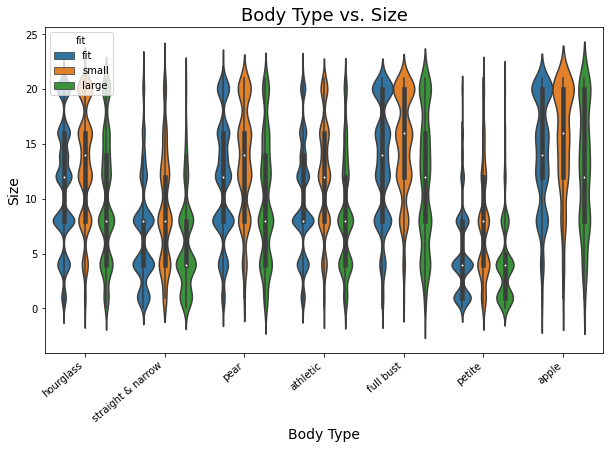

In [ ]:
plt.figure(figsize=(10,6))
b=sns.violinplot(x='body_type',y='size',data=data,hue='fit')
b.set_xticklabels(b.get_xticklabels(), rotation=40, ha="right")
plt.title('Body Type vs. Size', size = 18)
plt.xlabel('Body Type', size = 14)
plt.ylabel('Size', size = 14)
plt.show()

Based on the plot above, we can conclude that most people in this dataset have a body type of full bust and apple. Except for people with straight & narrow and petite body types who will choose a smaller size, there is not much difference in the clothing size between other body types. 


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


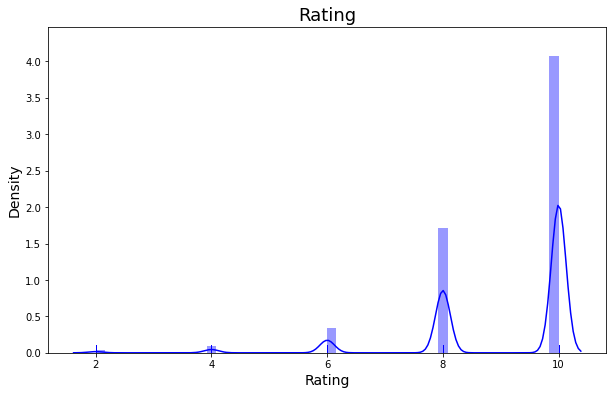

In [ ]:
#most of the clothes are betwen size 0 to 30, whatever the type it is.
plt.figure(figsize=(10,6))
sns.distplot(data['rating'], color="b", rug=True)
plt.title('Rating', size = 18)
plt.xlabel('Rating', size = 14)
plt.ylabel('Density', size = 14)
plt.show()

#**3. Analytical Findings**


## 3.1 Text Analysis

Checking All Reviews Column

In [ ]:
tdv = TfidfVectorizer()
tdv.fit(data.review_summary)
tdm = tdv.transform(data.review_summary)
tdv.vocabulary_

{'so': 9184,
 'many': 6129,
 'compliments': 2331,
 'felt': 3838,
 'glamourous': 4468,
 'dress': 3185,
 'arrived': 767,
 'on': 6954,
 'time': 10154,
 'and': 625,
 'in': 5184,
 'perfect': 7329,
 'condition': 2363,
 'was': 10897,
 'love': 5962,
 'with': 11117,
 'this': 10084,
 'traditional': 10273,
 'touch': 10249,
 'sass': 8525,
 'literally': 5849,
 'the': 10035,
 'cutest': 2693,
 'ever': 3566,
 'great': 4624,
 'beautifully': 1133,
 'made': 6058,
 'received': 8024,
 'lots': 5947,
 'of': 6902,
 'for': 4122,
 'black': 1288,
 'tie': 10129,
 'event': 3562,
 'everything': 3579,
 'it': 5357,
 'masquerade': 6187,
 'ball': 996,
 'we': 10933,
 'attended': 842,
 'fun': 4261,
 'to': 10181,
 'wear': 10936,
 'wouldn': 11199,
 'normally': 6802,
 'buy': 1687,
 'stunning': 9653,
 'new': 6714,
 'year': 11261,
 'eve': 3558,
 'wedding': 10957,
 'me': 6241,
 'feel': 3825,
 'confident': 2377,
 'sexy': 8764,
 'ordered': 7017,
 'as': 785,
 'replacement': 8181,
 'gown': 4579,
 'wore': 11161,
 'heart': 4815,
 'a

In [ ]:
#sentiment scores for summary_reviews
afinn=Afinn()
#afinn = afinn.Afinn()
lis =[]
for i in data.review_summary:
    sc = afinn.score(i)
    lis.append(sc)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


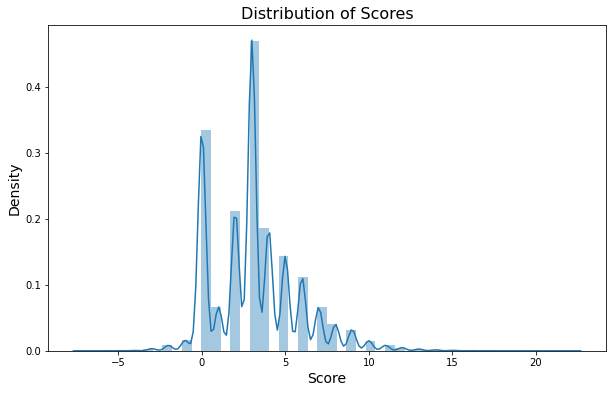

In [ ]:
plt.figure(figsize=(10,6))
sns.distplot(lis)
plt.title('Distribution of Scores', size = 16)
plt.xlabel('Score', size = 14)
plt.ylabel('Density', size = 14)
plt.show()

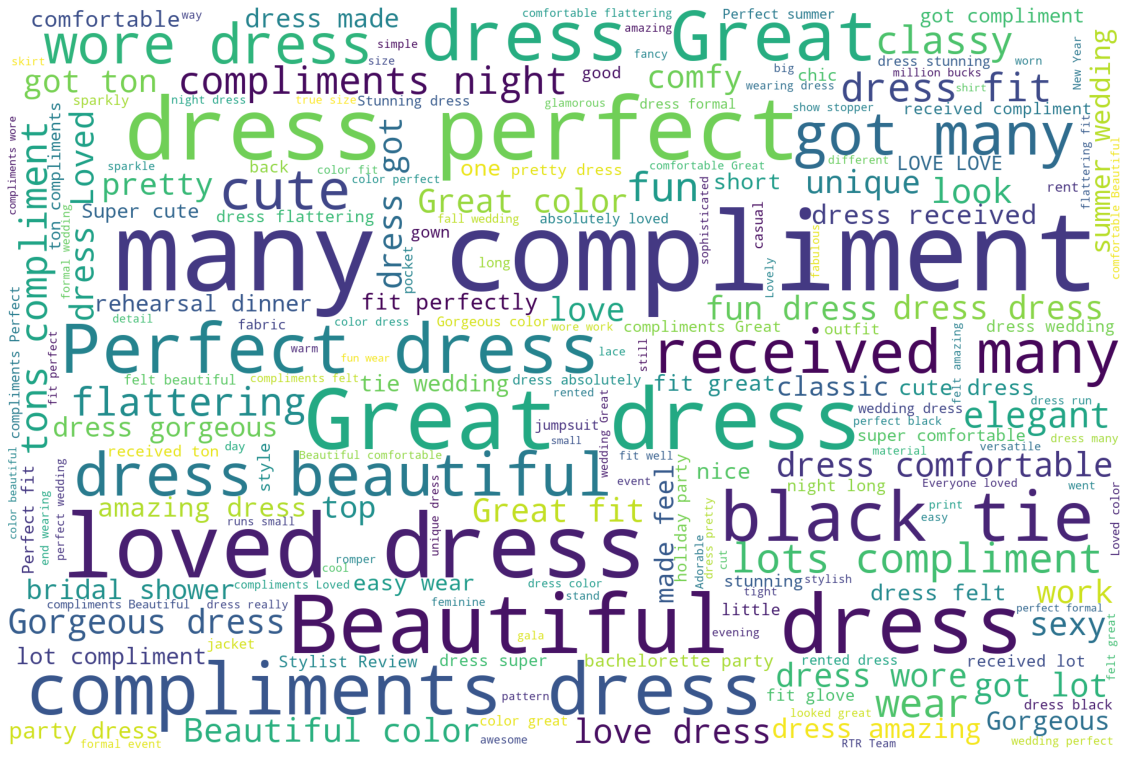

In [ ]:
#All comments
plt.figure(figsize=(20,16))
wc = WordCloud(background_color="white", width=1800, height=1200)
st = ''
for i in data.review_summary:
    st+= i
wordcloud = wc.generate(st)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [ ]:
data2=data
data2['sent']=lis

In [ ]:
data2_good=data2.loc[data2['sent']>5]
data2_bad=data2.loc[data2['sent']<0]
data2_good.sample(2)

,fit,user_id,bust_size,item_id,weight,rating,rented_for,review_text,body_type,review_summary,category,height,size,age,review_date,sent
107804,fit,308487,32c,1826136,138.0,8.0,party,This dress was so fun! I loved the shine of th...,hourglass,"Fun, flirty- a nice change from just another LBD",dress,59.0,8,28.0,2016-04-26,7.0
41929,fit,764889,38f,196859,130.0,10.0,party,I got lots of compliments on this pretty dress...,hourglass,"Great dress, If you have large Breasts Size UP...",maxi,66.0,15,37.0,2014-08-04,7.0


In [ ]:
nltk.download('stopwords') 
STOPWORDS = list(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


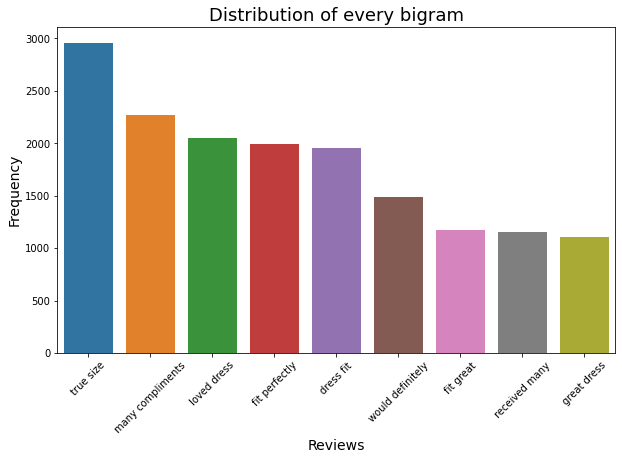

In [ ]:
#good comments
plt.figure(figsize=(10,6))
cv = CountVectorizer(ngram_range=(2,2),stop_words=STOPWORDS)
tokens = cv.fit_transform(data2_good['review_text'])

sum_words = tokens.sum(axis=0)
words_freq = [[word, sum_words[0, idx]] for word, idx in cv.vocabulary_.items()]
sorted(words_freq, key = lambda x: x[1], reverse=True)[:10]

good_comm=pd.DataFrame()
bigram=[]
freq=[]
for i in words_freq:
  bigram.append(i[0])
  freq.append(i[1])

good_comm['bigram']=bigram
good_comm['freq']=freq

good_comm.sort_values(by='freq',ascending=False,inplace=True)

good_comm_sub=good_comm.iloc[0:9]
sns.barplot(x='bigram',y='freq',data=good_comm_sub)
plt.xticks(rotation=45)
plt.title('Distribution of every bigram', size = 18)
plt.xlabel('Reviews', size = 14)
plt.ylabel('Frequency', size = 14)
plt.show()

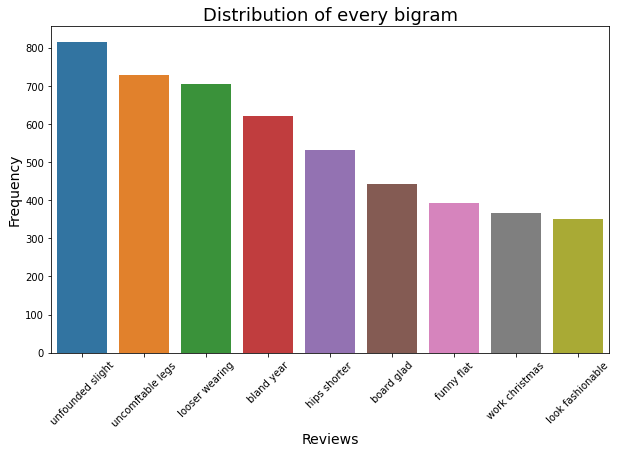

In [ ]:
#bad comments
plt.figure(figsize=(10,6))
cv2 = CountVectorizer(ngram_range=(2,2),stop_words=STOPWORDS)
tokens2 = cv2.fit_transform(data2_bad['review_text'])

sum_words2 = tokens2.sum(axis=0)
words_freq2 = [[word, sum_words[0, idx]] for word, idx in cv2.vocabulary_.items()]

bad_comm=pd.DataFrame()
bigram2=[]
freq2=[]
for i in words_freq2:
  bigram2.append(i[0])
  freq2.append(i[1])

bad_comm['bigram']=bigram2
bad_comm['freq']=freq2

bad_comm.sort_values(by='freq',ascending=False,inplace=True)

bad_comm_sub=bad_comm.iloc[0:9]
sns.barplot(x='bigram',y='freq',data=bad_comm_sub)
plt.xticks(rotation=45)
plt.title('Distribution of every bigram', size = 18)
plt.xlabel('Reviews', size = 14)
plt.ylabel('Frequency', size = 14)
plt.show()

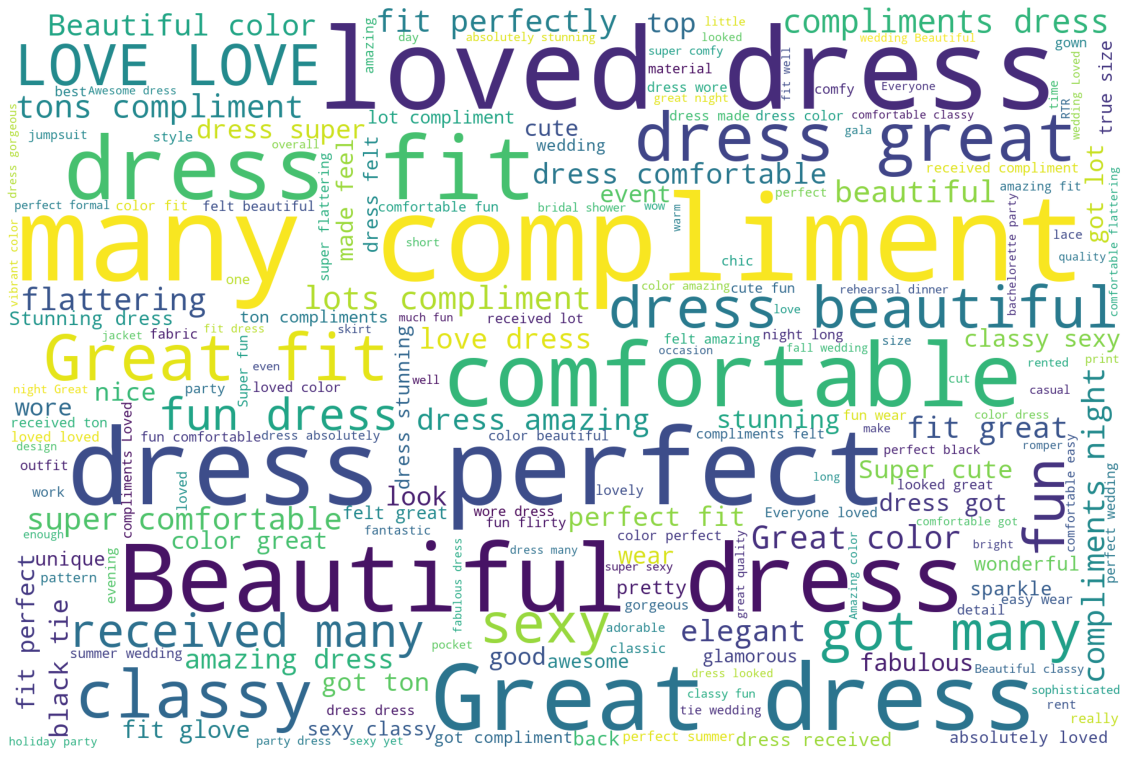

In [ ]:
plt.figure(figsize=(20,16))
wc = WordCloud(background_color="white", width=1800, height=1200)
st = ''
for i in data2_good.review_summary:
    st+= i
wordcloud = wc.generate(st)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

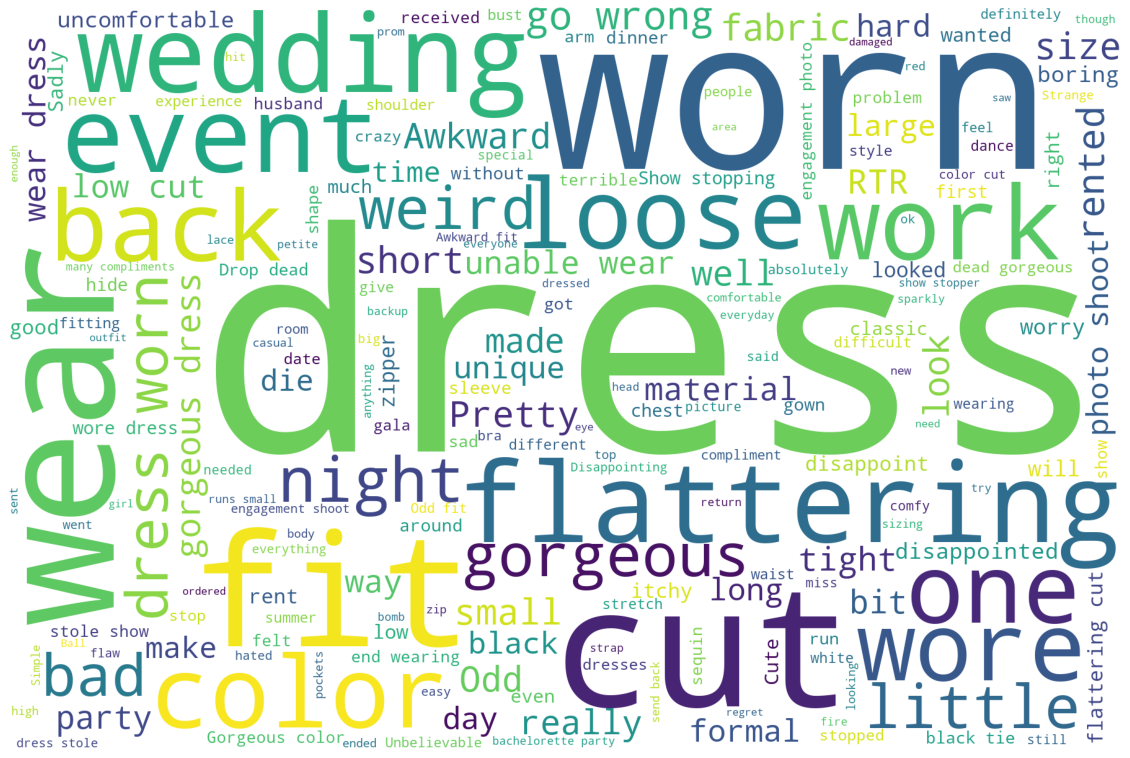

In [ ]:
plt.figure(figsize=(20,16))
wc = WordCloud(background_color="white", width=1800, height=1200)
st = ''
for i in data2_bad.review_summary:
    st+= i
wordcloud = wc.generate(st)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [ ]:
model = "en_core_web_md"
cli.download(model)

nlp = spacy.load(model)

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [ ]:
data2_good.sent.describe()

count    28195.000000
mean         7.477638
std          1.773820
min          6.000000
25%          6.000000
50%          7.000000
75%          8.000000
max         22.000000
Name: sent, dtype: float64

In [ ]:
corpus=[]
for words in data2_good['review_text']:
  corpus.append(words)

In [ ]:
corpus[1:20]

["This dress was absolutely gorgeous and I received so many compliments!  I wore it to a black tie NYE wedding, and even though it was short, I felt like the fabric, fit, and the way it sparkled made it fit in just fine with the other formal gowns.  I usually wear a 6 or an 8 in dresses.  I ordered a 4 and a 6, and true to other reviewers' comments, the 4 fit me very well.  The chest area was just a tad loose, but that typically happens when I try on dresses...nothing a more padded bra couldn't fix!  The cut and fit were very figure flattering.  By the end of the evening I experience a little chafing under my arms from the sequins, but that was after 5 hours and it was very minor.  Thank you RTR for a great first experience, I'll definitely be back!",
 'Fit great, super flattering',
 'I rented this for my birthday dinner at a downtown restaurant and loved every minute of it. This jumpsuit is super flattering, sexy, classy and comfortable. The only downside is the zipper, like other gir

In [ ]:
doc=list(nlp.pipe(corpus))
doc

[Fit was great. Maybe a little tight under the arms. ,
 This dress was absolutely gorgeous and I received so many compliments!  I wore it to a black tie NYE wedding, and even though it was short, I felt like the fabric, fit, and the way it sparkled made it fit in just fine with the other formal gowns.  I usually wear a 6 or an 8 in dresses.  I ordered a 4 and a 6, and true to other reviewers' comments, the 4 fit me very well.  The chest area was just a tad loose, but that typically happens when I try on dresses...nothing a more padded bra couldn't fix!  The cut and fit were very figure flattering.  By the end of the evening I experience a little chafing under my arms from the sequins, but that was after 5 hours and it was very minor.  Thank you RTR for a great first experience, I'll definitely be back!,
 Fit great, super flattering,
 I rented this for my birthday dinner at a downtown restaurant and loved every minute of it. This jumpsuit is super flattering, sexy, classy and comfortabl

## 3.2 Clustering Analysis


### 3.2.1 One-Hot Encoding and PCA

In [ ]:
data_dummified = pd.get_dummies(data, columns=['bust_size', 'body_type'])

In [ ]:
data_dummified.shape

(171128, 103)

In [ ]:
data_num = data_dummified.drop(columns=['fit','user_id','item_id','rating','rented_for','review_text','review_summary','size','review_date','category'], axis=1)
sc = StandardScaler()
data_scaled = sc.fit_transform(data_num)
pca = PCA()
pcs = pca.fit_transform(data_scaled)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


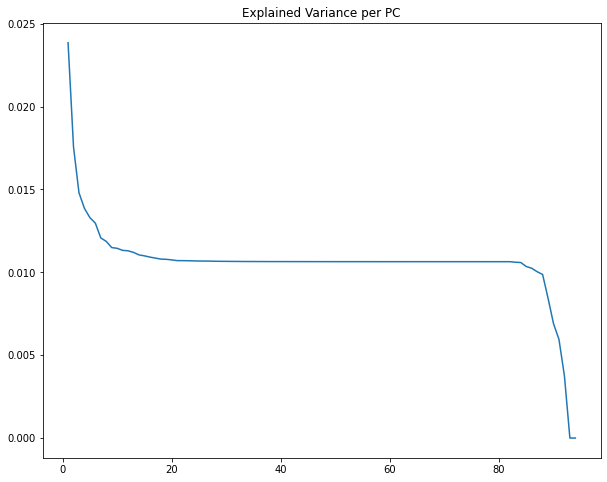

In [ ]:
plt.figure(figsize=(10,8))

varexp = pca.explained_variance_ratio_

plt.title("Explained Variance per PC")
sns.lineplot(range(1, len(varexp)+1), varexp)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


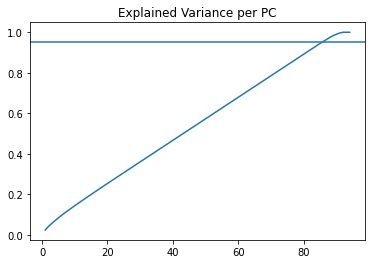

In [ ]:
plt.title("Explained Variance per PC")
sns.lineplot(range(1, len(varexp)+1), np.cumsum(varexp))
plt.axhline(.95)

In [ ]:
data_clust = pd.DataFrame(pcs[:,:80], columns=['pc'+str(i) for i in range(1,81)])
data_sample = data_clust.sample(25000, random_state=820)

### 3.2.2Hierarchical Clustering

In [ ]:
diste = pdist(data_sample.values)
distc = pdist(data_sample.values, metric="cosine")

hclust_e = linkage(diste)
hclust_c = linkage(distc)

LINKS = [hclust_e, hclust_c]
TITLE = ['Euclidean', 'Cosine']

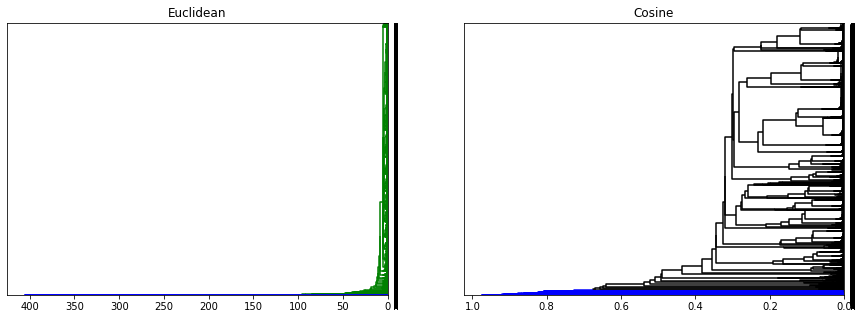

In [ ]:
plt.figure(figsize=(15, 5))

# loop and build our plot
for i, m in enumerate(LINKS):
  plt.subplot(1, 2, i+1)
  plt.title(TITLE[i])
  dendrogram(m,
            #  labels = ps.index,
             leaf_rotation=90,
            #  leaf_font_size=10,
             orientation="left")

In [ ]:
METHODS = ['single', 'complete', 'average', 'ward']
plt.figure(figsize=(20,5))


# loop and build our plot
for i, m in enumerate(METHODS):
  plt.subplot(1, 4, i+1)
  plt.title(m)
  dendrogram(linkage(distc, method=m), 
             leaf_rotation=90)

In [ ]:
hc_comp = linkage(data_sample, method="complete")
cluster = fcluster(hc_comp, 9, criterion='maxclust')

#### Profiling the Clusters

In [ ]:
data_sample_hclust = data.sample(25000, random_state=820)
data_sample_hclust['cluster'] = cluster
data_sample_hclust.groupby('cluster')['size'].mean().round()
data_sample_hclust.groupby('cluster')['age'].mean().round()
data_sample_hclust.groupby('cluster')['weight'].mean().round()
data_sample_hclust.groupby('cluster')['height'].mean().round()

### 3.2.3 K-Means Clustering

Vectorizing the Review Summary

In [ ]:
nlp = spacy.load('en_core_web_md')


In [ ]:
data_dummified_2 = pd.get_dummies(data= data_dummified, columns=['rented_for',"category"])

In [ ]:
data_kmeans = data_dummified_2.drop(['user_id','fit','review_text',"item_id",'review_date'],axis=1)

In [ ]:
data_kmeans.shape

(171128, 173)

In [ ]:
tk = [nlp(i).vector for i in list(data_kmeans.review_summary)]
d2 = pd.DataFrame(np.array(tk), columns=[i for i in range(0,300)])
d2.shape

(171128, 300)

In [ ]:
data_txt = data_kmeans.join(d2, how = 'inner')
data_txt.drop("review_summary",axis=1, inplace = True)

In [ ]:
sc = StandardScaler()
data_sca = sc.fit_transform(data_txt)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [ ]:
data_umap = umap.UMAP().fit_transform(data_sca)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


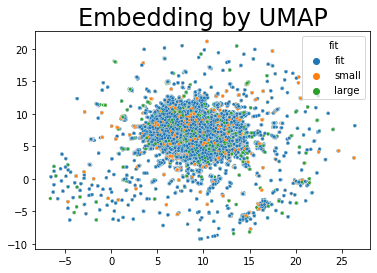

In [ ]:
sns.scatterplot(x=data_umap[:, 0],y= data_umap[:, 1],s=10,hue=data.fit)
plt.title('Embedding by UMAP', fontsize=24)
plt.show();

In [ ]:
data.head()

,fit,user_id,bust_size,item_id,weight,rating,rented_for,review_text,body_type,review_summary,category,height,size,age,review_date
0,fit,420272,34d,2260466,137.0,10.0,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,68.0,14,28.0,2016-04-20
1,fit,273551,34b,153475,132.0,10.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,66.0,12,36.0,2013-06-18
2,fit,909926,34c,126335,135.0,8.0,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,65.0,8,34.0,2014-02-12
3,fit,151944,34b,616682,145.0,10.0,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,69.0,12,27.0,2016-09-26
4,fit,734848,32b,364092,138.0,8.0,date,Didn't actually wear it. It fit perfectly. The...,athletic,Traditional with a touch a sass,dress,68.0,8,45.0,2016-04-30


In [ ]:
df_umap = pd.DataFrame(data_umap, columns = [i for i in range(0,2)])

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that a

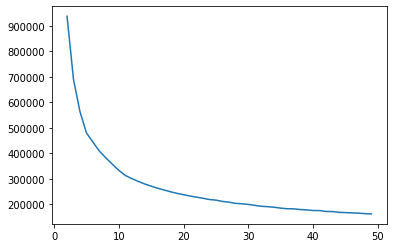

In [ ]:
inertia = []
for i in range(2,50):
    model = KMeans(n_clusters=i, random_state = 2807);
    model.fit(data_txt.sample(5000, random_state= 2807));
    pred = model.predict(data_txt.sample(5000, random_state= 2807));
    inertia.append(model.inertia_)
sns.lineplot(range(2,50), inertia)
plt.show();

In [ ]:
silo = []
for i in range(5,20):
    model = KMeans(n_clusters=i,random_state= 2807)
    model.fit(df_umap.sample(5000,random_state= 2807))
    pred = model.predict(df_umap.sample(5000, random_state= 2807))
    silo.append(metrics.silhouette_score(df_umap.sample(5000, random_state= 2807),pred))
sil = pd.DataFrame(silo, columns=['silhouette_score'])
sil['clusters'] = [i for i in range(5,20)]

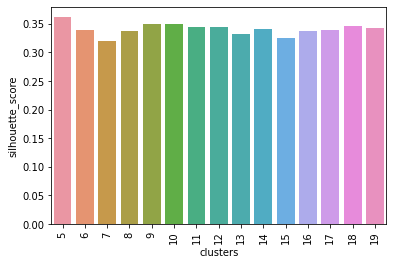

In [ ]:
sns.barplot(data = sil, y="silhouette_score", x= "clusters")
plt.xticks(rotation=90);

In [ ]:
kmean = KMeans(n_clusters= 5)
kmean.fit(data_umap)
k_5 = kmean.predict(data_umap)
len(k_5)

171128

In [ ]:
data_clustered = data.copy()
data_clustered['kmeans_5'] = k_5

In [ ]:
data_clustered.groupby('kmeans_5')['item_id'].count()

kmeans_5
0    50146
1    12039
2    10250
3    81249
4    17444
Name: item_id, dtype: int64

In [ ]:
def wordcloud_keybert(text):
  wc = WordCloud(background_color="white")
  kw_model = KeyBERT();
  st = ''
  for j in text:
   foo = " ".join(j.split())
   #print(len(foo.split()))
   #print(foo)
   try:
       keywords = kw_model.extract_keywords(foo,keyphrase_ngram_range=(1, 1), stop_words='english', 
                              use_maxsum=True, nr_candidates=20, top_n=5)
       #print(keywords)
       for i in keywords:
         st += (i[0] + ' ')
   except:
       print("Erron in line")
  wordcloud = wc.generate(st)
  plt.imshow(wordcloud)
  plt.axis("off")
  return plt.show();

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Library/Frameworks/Python.framewo

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Library/Frameworks/Python.framewo

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Library/Frameworks/Python.framewo

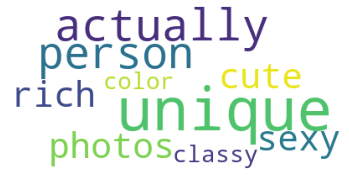

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Library/Frameworks/Python.framewo

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Library/Frameworks/Python.framewo

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Library/Frameworks/Python.framewo

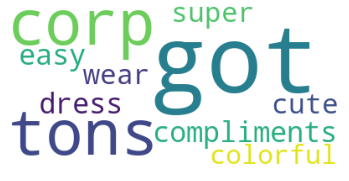

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Library/Frameworks/Python.framewo

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Library/Frameworks/Python.framewo

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


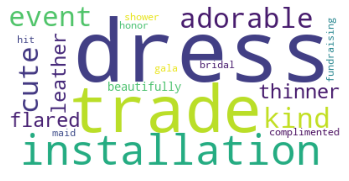

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Library/Frameworks/Python.framewo

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Library/Frameworks/Python.framewo

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Library/Frameworks/Python.framewo

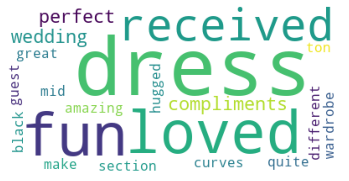

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Library/Frameworks/Python.framewo

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Library/Frameworks/Python.framewo

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


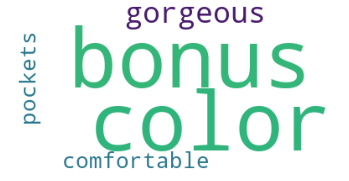

In [ ]:
wordcloud_keybert(data_clustered[data_clustered['kmeans_5']==0].review_summary.sample(20, random_state = 5103))
wordcloud_keybert(data_clustered[data_clustered['kmeans_5']==1].review_summary.sample(20, random_state = 5103))
wordcloud_keybert(data_clustered[data_clustered['kmeans_5']==2].review_summary.sample(20, random_state = 5103))
wordcloud_keybert(data_clustered[data_clustered['kmeans_5']==3].review_summary.sample(20, random_state = 5103))
wordcloud_keybert(data_clustered[data_clustered['kmeans_5']==4].review_summary.sample(20, random_state = 5103))

Using K- Nearest Neighbours for recommendation

In [ ]:
#pivoting the data_txt data frame
data_txt_pivot = data_txt.pivot

In [ ]:
#parsing the data frame to make a sparse matrix
from scipy.sparse import csr_matrix
data_sparse = csr_matrix(data_txt)

In [ ]:
# initializing knn with brute algorithm
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(algorithm='brute')

In [ ]:
#fitting the model with sparse data
knn.fit(data_sparse)

NearestNeighbors(algorithm='brute')

In [ ]:
#changing the index for item id to get recommendation on item_id
data_txt.index = data['item_id']

In [ ]:
# getting distances and suggestions based on id
distances, suggestions = knn.kneighbors(data_txt.iloc[12345, :].values.reshape(1,-1), n_neighbors = 6)

In [ ]:
data[data.index == suggestions[0,0]]

,fit,user_id,bust_size,item_id,weight,rating,rented_for,review_text,body_type,review_summary,category,height,size,age,review_date
12345,fit,361493,34c,1795593,107.0,10.0,vacation,"From the moment I saw this dress, I was in lov...",hourglass,In a word: Perfection!,maxi,61.0,4,31.0,2017-06-20


In [ ]:
data[data.index == suggestions[0,4]]

,fit,user_id,bust_size,item_id,weight,rating,rented_for,review_text,body_type,review_summary,category,height,size,age,review_date
44347,fit,953990,34a,1974220,108.0,10.0,wedding,Definitely need fashion tape to keep dress fro...,hourglass,Dress was beautiful! Received many compliments...,gown,61.0,3,30.0,2017-01-22


In [ ]:
#recomendation for size

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rfc = RandomForestRegressor(n_estimators=500,random_state= 820)

In [ ]:
data_rfc = data[['size','height','weight','age']]
data_rfc.head(3)

,size,height,weight,age
0,14,68.0,137.0,28.0
1,12,66.0,132.0,36.0
2,8,65.0,135.0,34.0


In [ ]:
X = data_rfc.drop('size',axis=1)
y = data_rfc['size']

In [ ]:
rfc.fit(X,y)

RandomForestRegressor(n_estimators=500, random_state=820)

In [ ]:
def size_predict():
    age = float(input("age = "))
    weight = float(input("weight = "))
    height = float(input("height = "))
    return rfc.predict(np.array([height,weight,age]).reshape(1,3))

In [ ]:
size_predict()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


array([6.58693451])